<a href="https://colab.research.google.com/github/Nimish-4/Web_scraping_NLP/blob/main/Project_scraping_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# Function to get the response object from Yahoo.com's finance page
# Top news articles of the moment, in the response object, are <a> tags of class 'js-content-viewer'

def get_page(url):
    response = requests.get(url)
    if not response.ok:
        print('Status code:', response.status_code)
        raise Exception('Failed to load page {}'.format(url))
    page_content = response.text
    doc = BeautifulSoup(page_content, 'html.parser')
    return doc


my_url = "https://finance.yahoo.com/news"

doc = get_page(my_url)

a_tags = doc.find_all('div', {'class': "content svelte-w27v8j"})
articles = []

for i in range(min(25,len(a_tags))):      #restricting to 25 articles
  articles.append(a_tags[i].find('a'))


In [14]:
# Searching for and saving the links to articles embedded in the <a> tags

links = []
url = ""                 #https://finance.yahoo.com/news

for anchor in articles:

  href=anchor.get('href')
  links.append(url+href)

print(links)

['https://finance.yahoo.com/news/what-if-working-women-dont-want-to-have-it-all-132522415.html', 'https://finance.yahoo.com/news/estonias-ruling-party-taps-climate-125345332.html', 'https://finance.yahoo.com/news/canadian-airline-westjet-cancels-least-122936147.html', 'https://finance.yahoo.com/news/supreme-court-nears-end-another-121012604.html', 'https://finance.yahoo.com/news/where-stock-market-headed-wild-120000096.html', 'https://finance.yahoo.com/news/egypt-eu-hold-investment-conference-105307381.html', 'https://finance.yahoo.com/news/top-artificial-intelligence-ai-stock-140000231.html', 'https://finance.yahoo.com/news/hims-hers-stock-buy-short-140000016.html', 'https://finance.yahoo.com/news/now-worst-time-buy-costco-134500487.html', 'https://finance.yahoo.com/news/best-warren-buffett-stocks-buy-131500681.html', 'https://finance.yahoo.com/news/1-dividend-growth-stock-buy-124500426.html', 'https://finance.yahoo.com/news/cathie-wood-sheds-4-3-123300409.html', 'https://finance.yaho

In [15]:
# Extracting the text from the actual news article using the links stored before

articles_text = []
headlines = []


for link in links:

  if link.find('video')==-1:                      # Excluding news links with videos instead of articles

    curr = ""
    res = requests.get(link)
    article = BeautifulSoup(res.text, 'html.parser')
    outer = article.find_all('div',{'class':'caas-body'})
    title = article.find('h1',{'id':'caas-lead-header-undefined'})


    if outer!= []:
      paras = outer[0].find_all('p')

      for i in range(1,len(paras)-1):               # Excluding <p> tags with irrelevant info. like date, time, author etc.
        curr+=paras[i].text
      articles_text.append(curr)


      headlines.append(title.text)



print('Number of articles: ',len(articles_text))
print(headlines)

Number of articles:  18
["What if working women don't want to have it all?", "Estonia's ruling party taps climate minister for the Baltic country's top job", 'Canadian airline WestJet cancels at least 150 flights following a surprise strike by mechanics union', "The Supreme Court nears the end of another momentous term. A decision on Trump's immunity looms", 'Where Stock Market Is Headed After Wild First Half: Five Charts', 'Egypt, EU hold an investment conference to help Cairo battle inflation and foreign currency crisis', 'Here Is My Top Artificial Intelligence (AI) Stock to Buy Right Now', 'Is Hims & Hers Stock a Buy After Short Report?', 'Is Now the Worst Time to Buy Costco Stock?', 'The Best Warren Buffett Stocks to Buy With $30,000 Right Now', 'Cathie Wood sheds $4.3 million of blazing tech stock', 'Q1 Earnings Roundup: Trinity (NYSE:TRN) And The Rest Of The Heavy Transportation Equipment Segment', 'Unpacking Q1 Earnings: Paramount (NASDAQ:PARA) In The Context Of Other Broadcasti

In [16]:
# Using TF-IDF to turn words from the articles into vectors

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words="english",
                        use_idf=True,
                        ngram_range=(1,1),        # Considering only 1-grams
                        min_df = 0.2,             # Cut words present in less than 20% of documents
                        max_df = 0.5)             # Cut words present in more than 50% of documents

tfidf = vectorizer.fit_transform(articles_text)
print(tfidf.shape)

(18, 229)


<ipython-input-17-f032a3be0c49>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='rank',y='term',data=ranked[:20], palette='Reds_r', ax=ax);


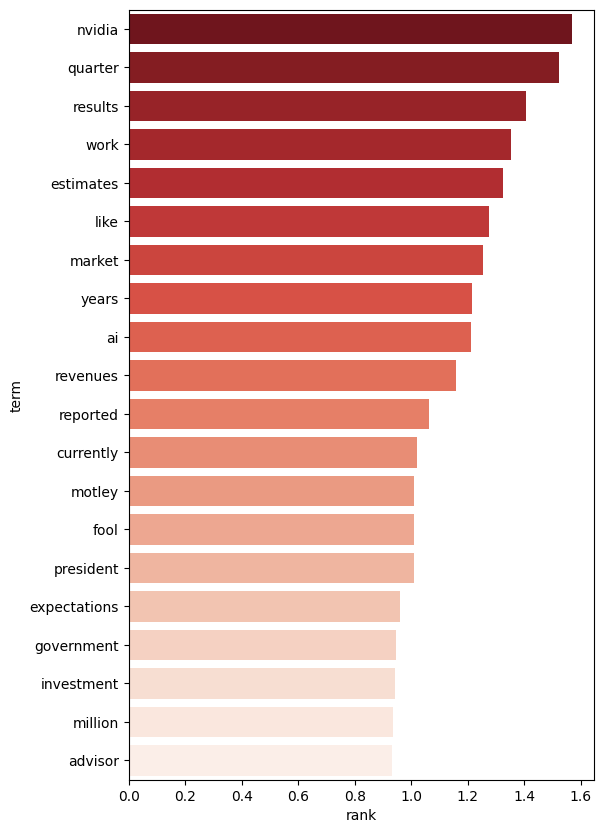

In [17]:
# Function to call the top ranked words in the vectorizer and using seaborn to visualize them

def rank_words(terms, feature_matrix):
    sums = feature_matrix.sum(axis=0)
    data = []
    for col, term in enumerate(terms):
        data.append( (term, sums[0,col]) )
    ranked = pd.DataFrame(data, columns=['term','rank']).sort_values('rank', ascending=False)
    return ranked

ranked = rank_words(terms=vectorizer.get_feature_names_out(), feature_matrix=tfidf)

fig, ax = plt.subplots(figsize=(6,10), ncols=1, nrows=1)
sns.barplot(x='rank',y='term',data=ranked[:20], palette='Reds_r', ax=ax);

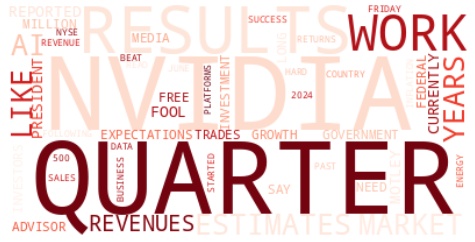

In [18]:
# Make a word cloud of the most frequent words using tfidf frequencies

dic = {ranked.loc[i,'term'].upper(): ranked.loc[i,'rank'] for i in range(0,len(ranked))}

from wordcloud import WordCloud
wordcloud = WordCloud(background_color='white',
                      max_words=50,
                      colormap='Reds').generate_from_frequencies(dic)

fig = plt.figure(1,figsize=(12,15),dpi=50)
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis('off')
plt.show()


In [19]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(tfidf)
kmeans.labels_

for i in range(3):
  print('\nNew category\n')
  for k in range(len(articles_text)):
    if kmeans.labels_[k]==i:
      print(headlines[k])



New category

The Supreme Court nears the end of another momentous term. A decision on Trump's immunity looms
Q1 Earnings Roundup: Trinity (NYSE:TRN) And The Rest Of The Heavy Transportation Equipment Segment
Unpacking Q1 Earnings: Paramount (NASDAQ:PARA) In The Context Of Other Broadcasting Stocks
Q1 Earnings Highs And Lows: Monster (NASDAQ:MNST) Vs The Rest Of The Beverages and Alcohol Stocks
Q1 Earnings Highs And Lows: Global Industrial (NYSE:GIC) Vs The Rest Of The Maintenance and Repair Distributors Stocks

New category

Where Stock Market Is Headed After Wild First Half: Five Charts
Egypt, EU hold an investment conference to help Cairo battle inflation and foreign currency crisis
Here Is My Top Artificial Intelligence (AI) Stock to Buy Right Now
Is Hims & Hers Stock a Buy After Short Report?
Is Now the Worst Time to Buy Costco Stock?
The Best Warren Buffett Stocks to Buy With $30,000 Right Now
Cathie Wood sheds $4.3 million of blazing tech stock
The other reason EV stock prices 